In [1]:
# Requirements
import pandas as pd
import numpy as np

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman, k_clique_communities

from numpy import linalg

import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
with open('data/wiki-RfA.txt') as f:
    wiki_txt = f.readlines()

In [3]:
# Print first lines of the document
wiki_txt[:16]

['SRC:Steel1943\n',
 'TGT:BDD\n',
 'VOT:1\n',
 'RES:1\n',
 'YEA:2013\n',
 'DAT:23:13, 19 April 2013\n',
 "TXT:'''Support''' as co-nom.\n",
 '\n',
 'SRC:Cuchullain\n',
 'TGT:BDD\n',
 'VOT:1\n',
 'RES:1\n',
 'YEA:2013\n',
 'DAT:01:04, 20 April 2013\n',
 "TXT:'''Support''' as nominator.--\n",
 '\n']

In [4]:
# Since is a text sourse create a dataframe
SOURCE = [wiki_txt[i].replace('SRC:','').replace('\n', '') for i in range(0,len(wiki_txt),8)]
TARGET = [wiki_txt[i].replace('TGT:','').replace('\n', '') for i in range(1,len(wiki_txt),8)]
VOTE   = [wiki_txt[i].replace('VOT:','').replace('\n', '') for i in range(2,len(wiki_txt),8)]
RESULT = [wiki_txt[i].replace('RES:','').replace('\n', '') for i in range(3,len(wiki_txt),8)]
YEAR = [wiki_txt[i].replace('YEA:','').replace('\n', '') for i in range(4,len(wiki_txt),8)]
DATE = [wiki_txt[i].replace('DAT:','').replace('\n', '') for i in range(5,len(wiki_txt),8)]
TEXT = [wiki_txt[i].replace('TXT:','').replace('\n', '') for i in range(6,len(wiki_txt),8)]

In [5]:
wiki = pd.DataFrame({'SOURCE': SOURCE,
                     'TARGET': TARGET,
                     'VOTE': VOTE,
                     'RESULT': RESULT,
                     'YEAR': YEAR,
                     'DATE': DATE,
                     'TEXT': TEXT})

print(wiki.shape)
wiki.head()

(198275, 7)


,SOURCE,TARGET,VOTE,RESULT,YEAR,DATE,TEXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


In [6]:
wiki[['VOTE', 'RESULT', 'YEAR']] = wiki[['VOTE', 'RESULT', 'YEAR']].astype(int)

In [7]:
wiki['YEAR'].value_counts()

2006    45325
2007    41541
2008    30479
2009    21375
2005    20239
2010    13970
2011     8556
2004     6541
2012     6474
2013     3572
2003      203
Name: YEAR, dtype: int64

## Finding the key(s) player(s) on each role (voter  or nominees) for each year on positive 

In [8]:
wiki_pos = wiki[(wiki['VOTE'] == 1)]

In [9]:
results_pos = []
B_vec = []

for year in wiki_pos['YEAR'].unique():
    print(year)
    df_year = wiki_pos[wiki_pos['YEAR']==year]
    
    # Creation of the graph
    G_pos = nx.MultiGraph()
    G_pos.add_edges_from(df_year[['SOURCE', 'TARGET', 'VOTE']].values)

    # Largest connected component
    Gcc = sorted(nx.connected_components(G_pos), key=len, reverse=True) 
    G_pos = nx.subgraph(G_pos, Gcc[0])
    edges = G_pos.number_of_edges() ##
    nodes = G_pos.number_of_nodes() ##
    
    # The largest value possible for a 
    mat_pos = nx.adjacency_matrix(G_pos)
    mat_pos = mat_pos.todense() # Retrieve the adjacency matrix
    lambda_value = max(linalg.eig(mat_pos)[0])
    max_a = np.round((1/lambda_value)/2,3) ##
    
    # Computing the bonacich centrality of each node in the network using max_a
    a = max_a
    M = np.linalg.inv(np.identity(n = mat_pos.shape[0]) - np.dot(a, mat_pos)) # Matrix M(g,a)
    B = list(np.dot(M,  np.ones(mat_pos.shape[0])).A1) # Vector of Bonacich centralities of each student
    
    
    # Scale down the BC with a very low value of alpha and get the total and average aggregated activity
    alpha = 0.01
    B = [i.real * alpha for i in B]
    agg_act = np.sum(B) ##
    avg_agg_act = np.mean(B)
    
    # Save data
    results_pos.append({
                        'year': year,
                        'nodes': nodes,
                        'edges:': edges,
                        'a' : max_a.real,
                        'alpha': alpha,
                        'tot_agg_act': agg_act,
                        'avg_agg_act': avg_agg_act
    })

2013
2012
2011
2010
2009
2008
2007
2006
2005
2004
2003


In [10]:
pos_agg_res = pd.DataFrame(results_pos).sort_values(by='year')
pos_agg_res['tot_agg_act'] = np.round(pos_agg_res['tot_agg_act'], 4)
pos_agg_res['avg_agg_act'] = np.round(pos_agg_res['avg_agg_act'], 4)
pos_agg_res

,year,nodes,edges:,a,alpha,tot_agg_act,avg_agg_act
10,2003,95,198,0.062,0.01,1.4444,0.0152
9,2004,649,5044,0.012,0.01,9.0353,0.0139
8,2005,1694,15256,0.007,0.01,21.0989,0.0125
7,2006,3058,29935,0.005,0.01,36.4430,0.0119
6,2007,3249,29589,0.006,0.01,40.2222,0.0124
5,2008,2500,20700,0.006,0.01,29.8785,0.0120
4,2009,1919,14206,0.007,0.01,23.4664,0.0122
3,2010,1460,9391,0.008,0.01,17.8402,0.0122
2,2011,1172,6249,0.010,0.01,14.6956,0.0125
1,2012,946,4297,0.012,0.01,11.9675,0.0127


In [238]:
# Export the table
pos_agg_res.drop(['nodes', 'tot_agg_act'], axis=1).to_csv('outputs/Pos_votes_agg_act.csv', index=False)

Key players

In [11]:
wiki_pos.sort_values(by='YEAR', inplace=True)

key_players_pos = []

for year in wiki_pos['YEAR'].unique():
    print(year)
    df_year = wiki_pos[wiki_pos['YEAR']==year]
    
    # Full graph and largest connected component
    G_pos = nx.MultiGraph()
    G_pos.add_edges_from(df_year[['SOURCE', 'TARGET', 'VOTE']].values)
    Gcc = sorted(nx.connected_components(G_pos), key=len, reverse=True) 
    G_pos = nx.subgraph(G_pos, Gcc[0])
    
    # Full aggregate activity from the previous step
    full_aa = [i for i in pos_agg_res[pos_agg_res['year']==year]['tot_agg_act']][0]
    
    # Voters of the year (in the giant component)
    voters = [voter for voter in df_year['SOURCE'].unique() if voter in G_pos.nodes()]
    
    # A value used previously
    a = [i for i in pos_agg_res[pos_agg_res['year']==year]['a']][0]
    
    
    # For each voter
    red_aa = [] # List to save decrease of agg. act in each iteration (after removing each voter)
    for node in voters:
        G_j = G_pos.copy() # Full graph
        G_j.remove_node(node) # Remove the voter

        # Compute the aggregate activity of G_j
        mat = nx.adjacency_matrix(G_j) # adjancency matrix
        mat = mat.todense()

        M = np.linalg.inv(np.identity(n = mat.shape[0]) - np.dot(a, mat)) # Matrix M(g,a)
        B = list(np.dot(M,  np.ones(mat.shape[0])).A1) # Vector of Bonacich centralities of each student
        alpha = 0.01
        B = [i.real * alpha for i in B]
        
        new_aa = np.sum(B) # agregate activity
        red_aa.append(full_aa  - new_aa) # Compute and add to the list the reduction in aggregated activity
    
    # Save data
    key_players_pos.append({
                        'year': year,
                        'nodes': voters,
                        'dec_agg_act': red_aa,
    })

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


In [17]:
# Save the information for the key players
with open('outputs/key_p_info.pkl', 'wb') as file:
    pickle.dump(key_players_pos, file)


In [10]:
# Load the data of key positive voters
with open('outputs/key_p_info.pkl', 'rb') as file:
    key_players_pos = pickle.load(file)

In [15]:
# Create a dataframe with results
concatenate_pos = []
for i in range(len(key_players_neg)):
    concatenate_pos.append(pd.DataFrame({'nodes': key_players_pos[i]['nodes'], 
                                         'dec_agg_act':key_players_pos[i]['dec_agg_act'],
                                         'year': key_players_pos[i]['year']}))

key_results_pos = pd.concat(concatenate_pos).reset_index(drop=True)  
key_results_pos.head()

,nodes,dec_agg_act,year
0,Jimregan,0.013503,2003
1,Fuzheado,0.023830,2003
2,Pakaran,0.065420,2003
3,Cyan,0.057282,2003
4,Cyp,0.036513,2003


<AxesSubplot:xlabel='year', ylabel='dec_agg_act'>

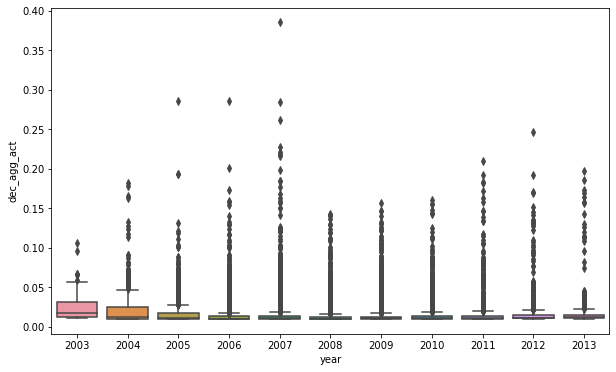

In [16]:
# Plot of distribution of the decrease in aggregated activity by removing voters
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=key_results_pos, x='year', y='dec_agg_act')

In [17]:
key_results_pos['kp'] = key_results_pos.groupby('year')['dec_agg_act'].transform(max)
key_pos_voters = key_results_pos[key_results_pos['dec_agg_act'] == key_results_pos['kp']]
key_pos_voters

,nodes,dec_agg_act,year,kp
9,Angela,0.106777,2003,0.106777
79,Neutrality,0.182715,2004,0.182715
644,Merovingian,0.286290,2005,0.286290
2187,Siva1979,0.286054,2006,0.286054
5095,Acalamari,0.385419,2007,0.385419
8132,Wisdom89,0.143052,2008,0.143052
10536,NuclearWarfare,0.156276,2009,0.156276
12391,Airplaneman,0.160128,2010,0.160128
13738,Boing! said Zebedee,0.210693,2011,0.210693
15238,SarahStierch,0.246848,2012,0.246848


## Finding the key(s) player(s) on each role (voter  or nominees) for each year on negative votes

In [12]:
wiki_neg = wiki[(wiki['VOTE'] == -1)]
print(wiki_neg.shape)

(41176, 7)


In [13]:
results_neg = []
B_vec = []

for year in wiki_neg['YEAR'].unique():
    print(year)
    df_year = wiki_neg[wiki_neg['YEAR']==year]
    
    # Creation of the graph
    G_neg = nx.MultiGraph()
    G_neg.add_edges_from(df_year[['SOURCE', 'TARGET', 'VOTE']].values)

    # Largest connected component
    Gcc = sorted(nx.connected_components(G_neg), key=len, reverse=True) 
    G_neg = nx.subgraph(G_neg, Gcc[0])
    edges = G_neg.number_of_edges() ##
    nodes = G_neg.number_of_nodes() ##
    
    # The largest value possible for a 
    mat_pos = nx.adjacency_matrix(G_neg)
    mat_pos = mat_pos.todense() # Retrieve the adjacency matrix
    lambda_value = max(linalg.eig(mat_pos)[0])
    max_a = np.round((1/lambda_value)/2,3) ##
    
    # Computing the bonacich centrality of each node in the network using max_a
    a = max_a
    M = np.linalg.inv(np.identity(n = mat_pos.shape[0]) - np.dot(a, mat_pos)) # Matrix M(g,a)
    B = list(np.dot(M,  np.ones(mat_pos.shape[0])).A1) # Vector of Bonacich centralities of each student
    
    
    # Scale down the BC with a very low value of alpha and get the total and average aggregated activity
    alpha = 0.01
    B = [i.real * alpha for i in B]
    agg_act = np.sum(B) ##
    avg_agg_act = np.mean(B)
    
    # Save data
    results_neg.append({
                        'year': year,
                        'nodes': nodes,
                        'edges:': edges,
                        'a' : max_a.real,
                        'alpha': alpha,
                        'tot_agg_act': agg_act,
                        'avg_agg_act': avg_agg_act
    })

2013
2012
2011
2010
2009
2008
2007
2006
2005
2004
2003


In [14]:
neg_agg_res = pd.DataFrame(results_neg).sort_values(by='year')
neg_agg_res['tot_agg_act'] = np.round(neg_agg_res['tot_agg_act'], 4)
neg_agg_res['avg_agg_act'] = np.round(neg_agg_res['avg_agg_act'], 4)

neg_agg_res

,year,nodes,edges:,a,alpha,tot_agg_act,avg_agg_act
10,2003,3,2,0.354,0.01,0.0589,0.0196
9,2004,360,843,0.039,0.01,4.9865,0.0139
8,2005,909,2836,0.028,0.01,12.2958,0.0135
7,2006,1922,9422,0.015,0.01,24.9841,0.0130
6,2007,1988,7924,0.019,0.01,26.1122,0.0131
5,2008,1589,6828,0.016,0.01,20.3607,0.0128
4,2009,1226,5035,0.018,0.01,16.1629,0.0132
3,2010,870,3238,0.021,0.01,11.5276,0.0133
2,2011,588,1665,0.031,0.01,8.0540,0.0137
1,2012,570,1687,0.028,0.01,7.7163,0.0135


In [236]:
# Export
neg_agg_res.drop(['nodes', 'tot_agg_act'], axis=1).to_csv('outputs/Neg_votes_agg_act.csv', index=False)

Trying to find the k key players for each year

In [15]:
wiki_neg.sort_values(by='YEAR', inplace=True)

key_players_neg = []

for year in wiki_neg['YEAR'].unique():
    print(year)
    df_year = wiki_neg[wiki_neg['YEAR']==year]
    
    # Full graph and largest connected component
    G_neg = nx.MultiGraph()
    G_neg.add_edges_from(df_year[['SOURCE', 'TARGET', 'VOTE']].values)
    Gcc = sorted(nx.connected_components(G_neg), key=len, reverse=True) 
    G_neg = nx.subgraph(G_neg, Gcc[0])
    
    # Full aggregate activity from the previous step
    full_aa = [i for i in neg_agg_res[neg_agg_res['year']==year]['tot_agg_act']][0]
    
    # Voters of the year (in the giant component)
    voters = [voter for voter in df_year['SOURCE'].unique() if voter in G_neg.nodes()]
    
    #
    a = [i for i in neg_agg_res[neg_agg_res['year']==year]['a']][0]
    
    
    # For each voter
    red_aa = [] # List to save decrease of agg. act in each iteration (after removing each voter)
    for node in voters:
        G_j = G_neg.copy() # Full graph
        G_j.remove_node(node) # Remove the voter

        # Compute the aggregate activity of G_j
        mat = nx.adjacency_matrix(G_j) # adjancency matrix
        mat = mat.todense()

        M = np.linalg.inv(np.identity(n = mat.shape[0]) - np.dot(a, mat)) # Matrix M(g,a)
        B = list(np.dot(M,  np.ones(mat.shape[0])).A1) # Vector of Bonacich centralities of each student
        alpha = 0.01
        B = [i.real * alpha for i in B]
        
        new_aa = np.sum(B) # agregate activity
        red_aa.append(full_aa  - new_aa) # Compute and add to the list the reduction in aggregated activity
    
    # Save data
    key_players_neg.append({
                        'year': year,
                        'nodes': voters,
                        'dec_agg_act': red_aa,
    })

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


In [18]:
# Save the information for the key players
with open('outputs/key_n_info.pkl', 'wb') as file:
    pickle.dump(key_players_neg, file)


In [9]:
# Load the data of key positive voters
with open('outputs/key_n_info.pkl', 'rb') as file:
    key_players_neg = pickle.load(file)

In [12]:
# Create a dataframe with results
concatenate_neg = []
for i in range(len(key_players_neg)):
    concatenate_neg.append(pd.DataFrame({'nodes': key_players_neg[i]['nodes'], 
                                         'dec_agg_act':key_players_neg[i]['dec_agg_act'],
                                         'year': key_players_neg[i]['year']}))

key_results_neg = pd.concat(concatenate_neg).reset_index(drop=True)  
key_results_neg.head()

,nodes,dec_agg_act,year
0,Cyan,0.027940,2003
1,Ugen64,0.027940,2003
2,Improv,0.017229,2004
3,Jengod,0.014449,2004
4,Pakaran,0.011233,2004


<AxesSubplot:xlabel='year', ylabel='dec_agg_act'>

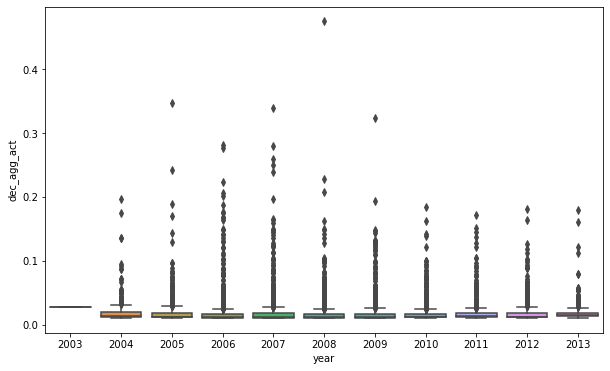

In [13]:
# Plot of distribution of the decrease in aggregated activity by removing voters
fig, ax = plt.subplots(figsize=(10, 6))
#sns.kdeplot(data=key_results_neg, x = 'dec_agg_act', hue='year')
sns.boxplot(data=key_results_neg, x='year', y='dec_agg_act')

In [14]:
key_results_neg['kp'] = key_results_neg.groupby('year')['dec_agg_act'].transform(max)
key_neg_voters = key_results_neg[key_results_neg['dec_agg_act'] == key_results_neg['kp']]
key_neg_voters

,nodes,dec_agg_act,year,kp
0,Cyan,0.027940,2003,0.027940
1,Ugen64,0.027940,2003,0.027940
112,Netoholic,0.196478,2004,0.196478
347,Boothy443,0.347392,2005,0.347392
985,Xoloz,0.280715,2006,0.280715
2638,Xoloz,0.339884,2007,0.339884
4150,Wisdom89,0.474783,2008,0.474783
5425,Ottava Rima,0.322969,2009,0.322969
6574,Fastily,0.183762,2010,0.183762
7256,Snottywong,0.171095,2011,0.171095


In [ ]:
### Graphs of mean activity (pos and neg) by year

## Logistic regression to effects of key voters on election outcomes

In [11]:
wiki.head()

,SOURCE,TARGET,VOTE,RESULT,YEAR,DATE,TEXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


In [18]:
# Dummies of the type of vote
wiki_ = pd.concat([wiki, pd.get_dummies(wiki['VOTE'].astype(str))], axis = 1)

In [19]:
# Inclution of the name of the key player for positive votes in each year and dummy that says if the key voter voted
wiki_ = pd.merge(wiki_, key_pos_voters[['year', 'nodes']], left_on = 'YEAR', right_on = 'year', how='left')
wiki_.rename(columns={"nodes": "POS_KV"}, inplace=True)
wiki_['POS_KV'] = np.where(wiki_['SOURCE']==wiki_['POS_KV'],1,0)

In [20]:
# Dummie for recieve a vote from a key voter in the negative network
wiki_ = pd.merge(wiki_, key_neg_voters[['year', 'nodes']], left_on = 'YEAR', right_on = 'year', how='left')
wiki_.rename(columns={"nodes": "NEG_KV"}, inplace=True)
wiki_['NEG_KV'] = np.where(wiki_['SOURCE']==wiki_['NEG_KV'],1,0)

wiki_.head()

,SOURCE,TARGET,VOTE,RESULT,YEAR,DATE,TEXT,-1,0,1,year_x,POS_KV,year_y,NEG_KV
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,0,0,1,2013,0,2013,0
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,0,0,1,2013,0,2013,0
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,0,0,1,2013,0,2013,0
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,0,0,1,2013,0,2013,0
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",0,0,1,2013,0,2013,0


In [21]:
# Dummy creation of a dumyy if the target was previously in a election process
wiki_['MONTH'] = wiki_['DATE'].str.split(' ', expand=True)[2]
wiki_['YEAR_MONTH'] = wiki['YEAR'].astype(str) + wiki_['MONTH']

nominees = wiki_[['YEAR_MONTH', 'TARGET']].drop_duplicates()

nominees['PREVIOUS'] = np.where(nominees.duplicated(subset=['TARGET'], keep='last') == True,1,0)
nominees['PREVIOUS'].value_counts()

wiki_ = pd.merge(wiki_, nominees, on = ['YEAR_MONTH', 'TARGET'])

In [22]:
# Aggregated data by election process
wiki_ep = wiki_.groupby(['TARGET', 'YEAR']).agg( 
                                                 POS_VOTES=('1', np.sum),
                                                 NEG_VOTES=('-1', np.sum),
                                                 NEU_VOTES=('0', np.sum),
                                                 KEY_POS_VOTER=('POS_KV', np.max),
                                                 KEY_NEG_VOTER=('NEG_KV', np.max),
                                                 PREVIOUS=('PREVIOUS', np.min),   
                                                 RESULT=('RESULT', np.min)
                                          ).replace(-1,0).reset_index()

# Inclution of number of nominees for year
nominees = wiki_[['YEAR', 'TARGET']].drop_duplicates()
n_nominees = nominees.groupby('YEAR').count().reset_index()
n_nominees.columns = ['YEAR','N_NOMINEES']

wiki_ep = pd.merge(wiki_ep, n_nominees, on='YEAR')


In [23]:
# Export descriptive statistics of the vars used to the logistic regression 
wiki_ep.groupby('RESULT').describe().T.to_csv('outputs/descriptive_df_logit.csv')

In [32]:
# Simple logistic stage 1
wiki_ep['intercept'] = 1
controls = ['YEAR', 'POS_VOTES', 'NEG_VOTES', 'NEU_VOTES', 'N_NOMINEES', 'PREVIOUS']
#controls = ['YEAR', 'NEU_VOTE_SHARE']
effects = ['intercept','KEY_POS_VOTER', 'KEY_NEG_VOTER']

logit_mod = sm.Logit(wiki_ep['RESULT'], wiki_ep[effects], )

logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.651691
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 RESULT   No. Observations:                 3814
Model:                          Logit   Df Residuals:                     3811
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Jun 2022   Pseudo R-squ.:                 0.05805
Time:                        20:40:35   Log-Likelihood:                -2485.5
converged:                       True   LL-Null:                       -2638.7
Covariance Type:            nonrobust   LLR p-value:                 2.986e-67
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -0.7227      0.053    -13.648      0.000      -0.826      -0.619
KEY_POS_VOTER     1.

In [29]:
# Simple logistic stage 1
controls = ['YEAR', 'N_NOMINEES', 'PREVIOUS']
#controls = ['YEAR', 'NEU_VOTE_SHARE']
effects = ['intercept','KEY_POS_VOTER', 'KEY_NEG_VOTER']

logit_mod = sm.Logit(wiki_ep['RESULT'], wiki_ep[effects + controls])

logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.613696
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 RESULT   No. Observations:                 3814
Model:                          Logit   Df Residuals:                     3808
Method:                           MLE   Df Model:                            5
Date:                Tue, 07 Jun 2022   Pseudo R-squ.:                  0.1130
Time:                        20:36:40   Log-Likelihood:                -2340.6
converged:                       True   LL-Null:                       -2638.7
Covariance Type:            nonrobust   LLR p-value:                1.353e-126
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept       617.5290     41.832     14.762      0.000     535.540     699.518
KEY_POS_VOTER     1.

In [30]:
# Simple logistic regression
controls = ['YEAR', 'N_NOMINEES', 'PREVIOUS', 'POS_VOTES', 'NEG_VOTES', 'NEU_VOTES']
#controls = ['YEAR', 'NEU_VOTE_SHARE']
effects = ['intercept','KEY_POS_VOTER', 'KEY_NEG_VOTER']

logit_mod = sm.Logit(wiki_ep['RESULT'], wiki_ep[effects + controls])

logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.182761
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 RESULT   No. Observations:                 3814
Model:                          Logit   Df Residuals:                     3805
Method:                           MLE   Df Model:                            8
Date:                Tue, 07 Jun 2022   Pseudo R-squ.:                  0.7358
Time:                        20:36:49   Log-Likelihood:                -697.05
converged:                       True   LL-Null:                       -2638.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept       696.4020     80.370      8.665      0.000     538.880     853.924
KEY_POS_VOTER     0